# **Transverse Field Ising Model**

## Index

- [Transverse Field Ising Model](#transverse-field-ising-model)
    - [Introduction](#introduction)
    - [Ground States and Symmetry](#ground-states-and-symmetry)
    - [Setting up the Hamiltonian](#setting-up-the-qubithamiltonian-in-quri)
- [VQE Optimization](#vqe-optimization)
    - [Cost and Gradient Estimators](#cost-function-and-gradient-estimator)
    - [Setting up VQE Optimization loop](#setting-up-vqe-optimization-loop)
    - [Benchmarking with different Ansatz]()
- [Statistical Phase Estimation](#statistical-phase-estimation-spe)
    - [Picking the Trial State](#trial-state)
    - [Setting up the QubitHamiltonian in Quri](#setting-up-the-qubithamiltonian-in-quri)
    - [LT22]()
- [QSCI](#qsci)
- [Quantum Phase Transition](#quantum-phase-transition)
    - [Magnetization](#magnetization)
    - [Correlation Length](#correlation-length-and-divergence-at-critical-point)
    - [Magnetic Susceptibility](#magnetic-susceptibility)
- [Reference](#reference)

*The goal of this tutorial will be to implement Transverse Field Ising Models (TFIM) using QURI-SDK. We will approximate the ground state of the TFIM Hamiltonian using VQE and further improving it using SPE, QSCI. Finally we will calculate the magnetization, magentic susceptibiluty, Correlation length and show divergence at the critical point (Quantum Phase Transition) which are relevant to Condensed Matter Physicist.*

## Introduction

Ising Model is a theoretical model to describe ferromagnetism in solids. It simplifies the complex properties of solids by assuming only nearest neighbor interaction between lattice sites and allowing only two opposite pointing orientations of each lattice site’s magnetic moment. Physically it's the opposite of an Ideal gas, as the particles are fixed but can interact compared to non-interacting moving particles in the Ideal gas. For details, see [Ising model](https://www.thphys.uni-heidelberg.de/~wolschin/statsem20_3s.pdf).

From a Computer Science perspective, NP-hard problems, including all of Karp's 21 NP-complete problems can be mapped to the Ising model with a polynomial overhead. Thus, any NP-hard problem can be reduced to finding the ground state of the Ising model. For further reference, look at [Ising formulations of NP-Complete problems](https://www.frontiersin.org/journals/physics/articles/10.3389/fphy.2014.00005/full).

Over time, Ising models have been applied to various other fields such as *Machine Learning (Hopfield networks)*, *Biology (Protein folding)*, and *Physics (Quantum phase transitions)*. The **Transverse Field Ising Model (TFIM)** is a quantum version of the Ising model, where spins are replaced by qubits and the interaction between spins is modified by a transverse magnetic field. This model is used to study quantum phase transitions and has applications in Quantum Computing and Condensed Matter Physics.


The Hamiltonian of the Transverse Field Ising Model is given by:

$$H = -J\sum_{i=1}^{N} X_i X_{i+1} - h\sum_{i=1}^N Z_i$$

- *$X$:* The Pauli $\sigma_x$ matrix (for spin measurement)
- *$Z$:* The Pauli $\sigma_z$ matrix (for transverse field) 
- *Ferromagnetic coupling ($J$)*: Favors alignment of neighboring spins along X.  
- *Transverse field ($h$)*: Induces quantum fluctuations, polarizing spins along J.
- The boundary condition is periodic, meaning the last spin interacts with the first spin.

**Note:** In most references, the Hamiltonian will have Pauli matrices in the opposite order, i.e., $H = -J\sum_{i=1}^{N-1} Z_{i+1} Z_i - h\sum_{i=1}^N X_i$. This is due to the convention of defining the spin along Z axis in Condensed Matter Physics. The reason we switch Pauli X and Z is due to the Z2 ansatz we will be using for the VQE. Everything else remains the same, if you are doing any calculation wrt to the standard TFIM Hamiltonian, just switch the Pauli matrices.

### Ground States and Symmetry

##### *h >> J (Paramagnetic Phase):* 
When h is much larger than J, the spins tend to align along the Z-axis, leading to magnetization in the Z direction (ferromagnetic phase). Thus, the two degenerate ground states are:
$$
|\psi^{0+}\rangle = \otimes_{n=1}^N | \uparrow \rangle_n, \quad |\psi^{0-}\rangle = \otimes_{n=1}^N | \downarrow \rangle_n
$$  
These exhibit non-zero magnetization $M =\pm N$, where $N$ is the number of spins.

##### *J >> h (Ferromagnetic Phase):* 
When J is much larger than h, the spins are polarized along the X-axis, leading to disordered state. 
Here Magnetization M = 0 and $\mathbf{Z}_2$ symmetry is preserved. The unique symmetric ground state is:
$$
|\psi^{0\to}\rangle = \bigotimes_{n=1}^N \frac{1}{\sqrt{2}} \left( | \uparrow \rangle_n + | \downarrow \rangle_n \right) = \otimes_{n=1}^N | \rightarrow \rangle_n
$$

The $\mathbb{Z}_2$ symmetry corresponds to a *global spin-flip* operation:
$ G = \otimes_i \sigma_i^z, $
which satisfies $G^2 = 1$, forming the cyclic group $\mathbb{Z}_2$.

Interaction term $\sigma_i^x \sigma_j^x$:
  $\quad G (\sigma_i^x \sigma_j^x) G^{-1} = \sigma_i^x \sigma_j^x \quad (\text{invariant}).$

Transverse field term $\sigma_i^x$:
  $\quad G (\sigma_i^z) G^{-1} = \sigma_i^z \quad (\text{invariant}).$

The Hamiltonian $H$ is invariant under $G$, confirming $\mathbb{Z}_2$ symmetry.

### Setting up the QubitHamiltonian in QURI

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence
from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix

def construct_TFIM_hamiltonian(J, h, n_qubits):
    hamiltonian = Operator()

    # Add Ising interaction terms (-J Σ X_i X_{i+1}) (Assuming periodic boundary conditions)
    for i in range(n_qubits):
        pauli_index = pauli_label('X'+str(i)+' X'+str((i+1)%n_qubits))
        hamiltonian.add_term(pauli_index, -J)

    # Add transverse field terms (-h Σ Z_i)
    for i in range(n_qubits):
        pauli_index = pauli_label('Z'+str(i))
        hamiltonian.add_term(pauli_index, -h)

    return hamiltonian

In [2]:
# Parameters
n_qubits = 12       # Number of spins/qubits
J = 1.0             # Interaction strength
h = 1.0             # Transverse field strength

hamiltonian = construct_TFIM_hamiltonian(J, h, n_qubits)

Since *n_qubits* is small, we can find the smallest eigenvalue (ground energy state) of the Hamiltonian matrix directly. This is only performed for benchmarking. For relistic physical systems involving large *n_qubits*, this computation is not feasible and we have to rely on Quantum Computing methods to find the approximate ground state.

In [3]:
## Ground eigenvalue and eigenvector computation using numpy (Will be later used for benchmarking)
vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

EXACT_GS_ENERGY = np.min(vals)
EXACT_GAP = vals[np.argsort(vals)][:2] @ [-1, 1]

print("E_0:", EXACT_GS_ENERGY)
print("Delta (E_1 - E_0)):", EXACT_GAP)

E_0: -15.322595151080778
Delta (E_1 - E_0)): 0.1310869256304681


## **VQE Optimization**

In case you're new to variational algorithms in QURI SDK, you should refer to this tutorial first on [Variational Algorithms](https://quri-sdk.qunasys.com/docs/tutorials/quri-parts/advanced/variational/).

### Cost Function and Gradient Estimator

We will first define closures (higher-order functions) that takes the Hamiltonian and parametric state as the parameter and returns cost function and gradient estimators for the VQE optimization. The `cost estimator` computes the expectation value of the Hamiltonian with respect to the parametric state, while the `gradient estimator` computes the gradient of the expectation value with respect to the parameters of the parametric state.

In [4]:
from quri_parts.core.estimator.gradient import create_parameter_shift_gradient_estimator
from quri_parts.qulacs.estimator import create_qulacs_vector_concurrent_parametric_estimator, create_qulacs_vector_parametric_estimator


estimator = create_qulacs_vector_parametric_estimator()

def H_cost_fn(hamiltonian, parametric_state):
    def cost_fn(param_values: Sequence[float]) -> Sequence[float]:
        estimate = estimator(hamiltonian, parametric_state, param_values)
        return estimate.value.real
    return cost_fn

In [5]:
concurrent_parametric_estimator = create_qulacs_vector_concurrent_parametric_estimator()
gradient_estimator = create_parameter_shift_gradient_estimator(concurrent_parametric_estimator)

def H_grad_fn(hamiltonian, parametric_state):
    def grad_fn(param_values: Sequence[float]) -> Sequence[float]:
        estimate = gradient_estimator(hamiltonian, parametric_state, param_values)
        return np.asarray([g.real for g in estimate.values])
    return grad_fn

### Setting up VQE Optimization loop

Next we will set up the VQE optimization loop, essentially setting up the cost and gradient estimators for the given hamiltonian and parametric state. After that updating the parameters of the parametric state using the gradient descent method with the ADAM Optimizer. QURI Parts provides a convenient `OptimizerStatus` class that will handle the optimizer convergence for us.

In [6]:
from quri_parts.algo.optimizer import Adam, OptimizerStatus

def run_vqe_loop(
    init_params: Sequence[float],
    cost_fn,
    grad_fn,
    optimizer,
    hamiltonian,
    parametric_state
):

    cost_fn = H_cost_fn(hamiltonian, parametric_state)
    grad_fn = H_grad_fn(hamiltonian, parametric_state)

    opt_state = optimizer.get_init_state(init_params)
    while True:
        opt_state = optimizer.step(opt_state, cost_fn, grad_fn)
        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            # print("Optimizer converged")
            break
    return opt_state

We will now set up the `vqe` function that takes the parametric circuit (Ansatz), optimizer (e.g. Adam) and returns the optimzied ground state, optimized ground state energy and the number of iterations taken to converge.

In [7]:
from quri_parts.core.state import quantum_state, apply_circuit

def vqe(
    parametric_circuit, 
    optimizer = Adam()
):
    cb_state = quantum_state(n_qubits, bits=0)
    parametric_state = apply_circuit(parametric_circuit, cb_state)

    init_params = np.random.random(parametric_circuit.parameter_count)
    vqe_state = run_vqe_loop(init_params, H_cost_fn, H_grad_fn, optimizer, hamiltonian, parametric_state)
    bound_state = parametric_state.bind_parameters(vqe_state.params)
    
    return bound_state, vqe_state.cost, vqe_state.params, vqe_state.niter

### Benchmarking with different Ansatz

We will benchmark the VQE optimization with different ansatz, such as Z2Ansatz, SymmetryPreservingReal, and HardwareEfficientReal.

In [8]:
from quri_parts.algo.ansatz import Z2SymmetryPreservingReal, SymmetryPreserving, HardwareEfficientReal
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

#### *Symmetry Preserving Real Ansatz*

The `SymmetryPreservingReal` respects particle number, total spin, spin projection, and time-reversal symmetries of the initial state. For further details, refer to this [paper](https://www.nature.com/articles/s41534-019-0240-1)

In [9]:
spr_parametric_circuit = SymmetryPreserving(n_qubits, 7)
draw_circuit(spr_parametric_circuit)

                                                           ___                  
                                                          |CX |                 
----------------------------------------------------------|35 |-----------------
                                                          |___|                 
   ___                                             ___      |      ___     ___  
  |CX |                                           |CX |     |     |PRZ|   |PRY| 
--|0  |---------------------●---------------------|6  |-----●-----|36 |---|37 |-
  |___|                     |                     |___|           |___|   |___| 
    |      ___     ___     _|_     ___     ___      |      ___                  
    |     |PRZ|   |PRY|   |CX |   |PRY|   |PRZ|     |     |CX |                 
----●-----|1  |---|2  |---|3  |---|4  |---|5  |-----●-----|42 |-----------------
          |___|   |___|   |___|   |___|   |___|           |___|                 
   ___                      

In [11]:
spr_bound_state, spr_ground_energy, spr_params, spr_num_iter = vqe(spr_parametric_circuit)
print("Optimized value:", spr_ground_energy)
print("Optimized parameter:", spr_params)
print("Iterations:", spr_num_iter)

Optimized value: -11.999999999999957
Optimized parameter: [0.21052007 0.71449233 0.3178199  0.95134433 0.73029416 0.55741018
 0.43094966 0.46089287 0.10355425 0.06652777 0.55988797 0.55518257
 0.56782323 0.43421207 0.08955908 0.51009766 0.86115693 0.65975796
 0.82545506 0.44710042 0.42167934 0.96808312 0.38169526 0.46974915
 0.74270551 0.02805887 0.22124735 0.45700119 0.11527744 0.81180483
 0.67836734 0.58664458 0.71465532 0.88662997 0.81360144 0.88618393
 0.78323393 0.3781063  0.72823157 0.51641802 0.30605244 0.74365972
 0.85584198 0.33515655 0.98051332 0.07900982 0.71114119 0.81012295
 0.22740898 0.02260241 0.36429887 0.57454172 0.46977609 0.08677592
 0.11471084 0.41637632 0.23090628 0.71739581 0.80798169 0.11883856
 0.61709388 0.10346364 0.09526051 0.54971215 0.35431486 0.09879269
 0.93578993 0.31261146 0.3040262  0.56959077 0.99121973 0.13804518
 0.0149846  0.87199855 0.0947964  0.89791297 0.17722542 0.16293335
 0.18656535 0.46023066 0.73708635 0.88004041 0.49428881 0.18114428
 0.9

#### *Z2 Symmetry Preserving Real Ansatz*

The `Z2SymmetryPreservingReal` ansatz is based of preserving the $\mathbb{Z}_2$ symmetry of the TFIM Hamiltonian we had defined at the start. For further details on the Z2 ansatz, refer to this [paper](https://arxiv.org/abs/2404.08548).

In [12]:
z2_parametric_circuit = Z2SymmetryPreservingReal(n_qubits, 7)
draw_circuit(z2_parametric_circuit)

                           ___     ___     ___                             ___  
                          |PR |   |PRZ|   |PR |                           |PR | 
--------------------------|20 |---|21 |---|23 |---------------------------|64 |-
                          |   |   |___|   |   |                           |   | 
   ___     ___     ___    |   |    ___    |   |    ___     ___     ___    |   | 
  |PR |   |PRZ|   |PR |   |   |   |PRZ|   |   |   |PR |   |PRZ|   |PR |   |   | 
--|0  |---|1  |---|3  |---|   |---|22 |---|   |---|44 |---|45 |---|47 |---|   |-
  |   |   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |   |   |___| 
  |   |    ___    |   |    ___     ___     ___    |   |    ___    |   |    ___  
  |   |   |PRZ|   |   |   |PR |   |PRZ|   |PR |   |   |   |PRZ|   |   |   |PR | 
--|   |---|2  |---|   |---|24 |---|25 |---|27 |---|   |---|46 |---|   |---|68 |-
  |___|   |___|   |___|   |   |   |___|   |   |   |___|   |___|   |___|   |   | 
   ___     ___     ___    | 

In [13]:
Z2_bound_state, Z2_ground_energy, Z2_params, Z2_num_iter = vqe(z2_parametric_circuit)
print("Optimized value:", Z2_ground_energy)
print("Optimized parameter:", Z2_params)
print("Iterations:", Z2_num_iter)

Optimized value: -15.21001519145036
Optimized parameter: [ 0.88909452  0.46972801  0.48712793  0.87089312  0.90069392  0.02713317
  0.81505317  0.01930821  0.83370103  0.63020493  0.86555162  0.97948232
 -0.28347116 -0.2500481   0.02333523  0.28985561  0.32379916  0.53461675
  0.73704324  0.96173131  0.5884304  -0.08307037  0.36313016  1.1656298
 -0.02030727  0.30004243 -0.30057942  0.04088087 -1.0251256  -0.83724473
  0.80293678  0.64454116  0.83304864  0.50268498  0.73359854  0.53934669
  0.22668629  0.07254481  0.99658881  0.30028797  0.45964014  0.54139948
 -0.19116053  0.4461981  -0.15097732  0.3347052  -0.09767279  0.50898203
  0.3928397   1.55926475  1.35696915  1.34357993  1.03977503  0.68370438
  0.66674892  0.07045692  0.64523408  0.46655474 -0.02371773  0.06776422
 -0.02521829  0.06031952  0.30912515  0.01531457  0.35456086  0.52516585
  1.21781463  1.35017965  0.57069538  0.11482737  0.16028453  1.62078481
  0.3943288   0.11760703  0.40314546  0.95120121  0.60676283  0.0470

#### *Hardware Efficient Real Ansatz*

The `HardwareEfficientReal` ansatz is a variational ansatz that is specifically meant for small molecules and quantum magnets. For further details on the HardwareEfficientReal ansatz, refer to this [paper](https://www.nature.com/articles/nature23879).

In [ ]:
hardware_parametric_circuit = HardwareEfficientReal(n_qubits, 7)

   ___                     ___                     ___                     ___  
  |PRY|                   |PRY|                   |PRY|                   |PRY| 
--|0  |-------------●-----|23 |-------------●-----|46 |-------------●-----|69 |-
  |___|             |     |___|             |     |___|             |     |___| 
   ___             _|_     ___             _|_     ___             _|_     ___  
  |PRY|           |CZ |   |PRY|           |CZ |   |PRY|           |CZ |   |PRY| 
--|1  |-----●-----|17 |---|24 |-----●-----|40 |---|47 |-----●-----|63 |---|70 |-
  |___|     |     |___|   |___|     |     |___|   |___|     |     |___|   |___| 
   ___     _|_             ___     _|_             ___     _|_             ___  
  |PRY|   |CZ |           |PRY|   |CZ |           |PRY|   |CZ |           |PRY| 
--|2  |---|12 |-----●-----|25 |---|35 |-----●-----|48 |---|58 |-----●-----|71 |-
  |___|   |___|     |     |___|   |___|     |     |___|   |___|     |     |___| 
   ___             _|_     _

In [15]:
he_bound_state, he_ground_energy, he_params, he_num_iter = vqe(hardware_parametric_circuit)
print("Optimized value:", he_ground_energy)
print("Optimized parameter:", he_params)
print("Iterations:", he_num_iter)

Optimized value: -15.189118751238702
Optimized parameter: [ 1.29967051e+00 -2.46825989e-01  5.52203871e-01  2.90043191e-01
 -5.86422285e-02  7.54101723e-01  8.41022786e-01 -2.13140068e-03
  9.15425700e-01  1.78953031e+00  1.40384145e+00  1.22615064e+00
  1.23429126e+00  6.07785964e-01  4.67990801e-01  1.00926349e+00
  4.14143569e-02  3.45551367e-01  1.09925456e+00  1.50650433e-03
  3.88530101e-01  6.23287471e-01  8.43174376e-01  5.68157204e-01
  6.94825337e-01  6.58971973e-01 -3.76045991e-01  5.07929475e-01
 -2.01934720e-02  9.90356569e-01  1.08503568e+00  1.45336455e-01
  1.61077584e+00  1.74216713e+00  9.22869495e-01  9.63844228e-01
  5.73866218e-01  1.54523671e-01  1.40550895e-02  1.27762573e+00
  4.11759709e-01  8.48172291e-01  3.56329155e-01 -1.04995476e-02
  7.66978159e-01  2.95075481e-01  1.51912590e+00  1.03127181e+00
  1.14264306e+00  6.00737954e-01  3.44340310e-01  1.03780425e+00
  5.65620489e-02  1.03923487e-01  2.24662012e-03 -1.14875396e-01
  9.29366251e-01  7.80219327e-01

Based on the above test runs, we can see that the `Z2SymmetryPreservingReal` ansatz performs the best in terms of convergence and accuracy of the ground state energy. The `HardwareEfficientReal` ansatz also performs well, but the `SymmetryPreservingReal` ansatz does not perform as well as the other two.

In [ ]:
Plot optimization energy
Remove draw circuit

## **Statistical Phase Estimation (SPE):**

Statistical Phase Estimation (SPE) is a ground state energy estimation (GSEE) algorithm meant to run on Early Fault Tolerant Quantum Computing (EFTQC) architectures. It's a NISQ-friendly variant of the Quantum Phase Estimation (QPE) algorithm. Instead of using quantum Fourier transform, it uses repeated measurements and classical postprocessing to estimate the phase.

Essentially SPE needs a shorter depth circuit than Quantum Phase Estimation (QPE) which requires longer circuit depth and fully fault tolerant architecture due to full Quantum Fourier Transform (QFT). For further details, you can refer to this [notebook](https://github.com/QunaSys/quri-sdk-notebooks/blob/main/quri_sdk_notebooks/examples/0_quri-algo-vm/1_spe/1_spe.ipynb) or the [original paper](https://arxiv.org/abs/2409.07749)

### Trial State

The goal of phase estimation is to estimate the phase $\phi$ in 
$U|\psi\rangle = e^{2\pi i \phi} |\psi\rangle$. But this only makes sense if we have a trial state $|\psi\rangle$ is an eigenstate of $U$.

In practice, we don't have access to the exact eigenstate of the Hamiltonian $H$, so we need to use a trial state which we hope has some overlap with the ground state.

$$U|\psi_{\text{trial}}\rangle = \sum_{j} c_j |\phi_j\rangle$$

$$U^k|\psi_{\text{trial}}\rangle = \sum_{j} c_j e^{2\pi i k \phi_j} |\phi_j\rangle$$

When you measure and statistically analyze the results, the phase estimation algorithm **amplifies the dominant phase(s)** — especially those for which $|c_j|^2$ is largest. We will be using the ground state obtained from the VQE optimization as the trial state for the SPE algorithm.

In [19]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector

gs_overlap = np.abs(evaluate_state_to_vector(Z2_bound_state).vector @ vecs[:, 0])**2
print(f"Overlap between the chosen state and the exact grounds state vector: {gs_overlap: .1e}")

Overlap between the chosen state and the exact grounds state vector:  9.4e-01


### Qubit Hamiltonian

 In SPE to estimate the ground state of a Hamiltonian, we need to encode our Hamiltonian into a controlled time evolution circuit ($e^{-i H t}$). Here we will do this time evolution with Trotterization. In QURI Parts, we wrap the hamiltonian into QubitHamiltonianInput for encoding into a circuit later.

In [16]:
from quri_algo.problem import QubitHamiltonianInput

qubit_hamiltonian = QubitHamiltonianInput(n_qubits, hamiltonian)

The SPE algorithm requires an esimtation of $<e^{-iHt}>$ on different evolution time $t$. We build the exact estimator and another one that based on Hadamard test with Trotterized time evolution operator.

In [17]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterControlledTimeEvolutionCircuitFactory
from quri_algo.core.estimator.time_evolution_estimator.trotter import TrotterTimeEvolutionHadamardTest


# Setting the num_trotter steps to 30
trotter_concotrolled_time_evo_circuit_factory = (
    TrotterControlledTimeEvolutionCircuitFactory(qubit_hamiltonian, n_trotter=30)
)

# Time-evolution with t=1
c_time_evo = trotter_concotrolled_time_evo_circuit_factory(evolution_time=1)

sampler = create_qulacs_vector_sampler()
trotter_time_evolution_estimator = TrotterTimeEvolutionHadamardTest(qubit_hamiltonian, sampler, 50)

### LT22

In [18]:
from quri_algo.algo.phase_estimation.spe import StepFunctionParam
from quri_algo.algo.phase_estimation.spe.lt22 import SingleSignalLT22GSEE

# Initializing the parameters for 
d_max = 1000
delta = 1e-4
n_sample = 10000
tau = 1 / 20
eta = 0.4

signal_param = StepFunctionParam(d=d_max, delta=delta, n_sample=n_sample)
lt22_algorithm = SingleSignalLT22GSEE(trotter_time_evolution_estimator, tau=tau)
spe_result = lt22_algorithm(Z2_bound_state, signal_param, eta)

lt22_gs_energy = spe_result.phase / tau
print(f"The obtained ground state energy is {lt22_gs_energy}")
print(f"The error is = {abs(lt22_gs_energy - np.min(vals))}")

The obtained ground state energy is -15.321354631241611
The error is = 0.0012405198391665095


Add summary of the results.

The obatined ground state energy is really close to the exact ground state energy. But SPE is extremely slow, for quicker benchmarking we will be using QSCI (Quantum Selected Configuration Interaction) as explained in the next section.

## **QSCI**

Quantum Selected Configuration Interaction (QSCI) is a hybrid quantum-classical algorithms for calculating the ground- and excited-state energies for a given Hamiltonian. It works on top of an approximate ground state estimated using VQE or by some other method. Then, by sampling the state in the computational basis, which is hard for classical computation in general, one can identify the basis states that are important for reproducing the ground state. The Hamiltonian in the subspace spanned by those important configurations is diagonalized on classical computers to output the ground-state energy and the corresponding eigenvector. The excited-state energies can be obtained similarly. The result is robust against statistical and physical errors. For further details, refer to this [notebook](https://github.com/QunaSys/quri-sdk-notebooks/blob/main/quri_sdk_notebooks/examples/0_quri-algo-vm/0_qsci/0_qsci.ipynb) or the [original paper](https://arxiv.org/abs/2302.11320).

In [23]:
BASIS_STATES = 2000
TOTAL_SHOTS = 1000000

In [24]:
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler
from quri_parts_qsci import qsci

sampler = create_qulacs_vector_concurrent_sampler()
eigs, ground_state = qsci(
    hamiltonian, [Z2_bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
)

In [25]:
print("Ground state energy as per QSCI:", eigs[0])
print("Error (QSCI Ground energy - Actual Ground State energy):", np.abs(eigs[0] - np.min(vals)))

Ground state energy as per QSCI: -15.319753209071127
Error (QSCI Ground energy - Actual Ground State energy): 0.002841942009650822


As you can observe, QSCI is extremely fast with accuracy comparable to SPE. To further increase the accuracy, you can increase the number of basis state or total shots. 

## **Quantum Phase Transition**:

Quantum phase transition is defined as the phenomenon where a major re-structuring of the ground state of a Quantum mechanical system occurs as a parameter of the Hamiltonian of the system is varied.

In Transverse Field Ising Model between the limits, $h << J$ and $h >> J$, the nature of the ground state changes. When $h >> J$ there are two ground states, with opposite signs of magnetization. When $J >> h$ there is a single ground state with zero magnetization. The transverse Ising model is interesting because it exhibits a second order “quantum phase transition” at a critical value of $\frac{h}{J}$. Here, a doublet of degenerate ground states, each with nonzero spontaneous magnetization must merge to form a unique ground state with zero magnetization. The quantum phase transition is of “second order” because the ground state energy, as a function of the parameter which is being varied to find the phase transition, has a discontinuous second derivative.

### **Magnetization**

The magnetization of the system is the sum of magnetic moment per spin. Here by magnetization we mean the Longitudinal Magnetization along the X-axis.

$$
M_x = \langle \sum_{n=1}^N \sigma_n^x \rangle
$$

In [72]:
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
qulacs_estimator = create_qulacs_vector_estimator()

magnetization_operator = Operator()
for i in range(n_qubits):
    pauli_index = pauli_label('Z'+str(i))
    magnetization_operator.add_term(pauli_index, 1)

def calculate_magnetization(quantum_state):
    return 1/n_qubits * np.real(qulacs_estimator(magnetization_operator, quantum_state))[0]


def calculate_magnetization_qsci_ground_state(ground_state):
    coeff, cb_states = ground_state[0]
    magnetization = 0

    for i in range(len(coeff)):
        magnetization += coeff[i]**2 * calculate_magnetization(cb_states[i])

    return magnetization
    

In [73]:
print("Magnetization for Z2 Ansatz Ground State Obtained:", calculate_magnetization(Z2_bound_state))

Magnetization for Z2 Ansatz Ground State Obtained: 0.58921459193004


In [74]:
print("Magnetization for QSCI Ground State Obtained:", calculate_magnetization_qsci_ground_state(ground_state))

Magnetization for QSCI Ground State Obtained: 0.6404087227415661


### **Correlation Length and Divergence at Critical point**

The *Correlation length* of a Quantum many body system quantifies how spins at different lattice sites are correlated for the ground state. For the *Transverse Field Ising Model (TFIM)*, it is defined as:

$$
C(r) = \langle \sigma_i^x \sigma_{i+r}^x \rangle - \langle \sigma_i^x \rangle \langle \sigma_{i+r}^x \rangle,
$$

where $r = |i - j|$ is the distance between spins. The *correlation length* $\xi$ is the characteristic length scale over which these correlations decay.

We will first define the various operators, you see in the above formula

In [ ]:
def C_r(quantum_state, r):
    pair_corr_operator = Operator()
    for i in range(n_qubits):
        if i+r >= n_qubits:
            break
        pauli_index = pauli_label('X'+str(i)+' X'+str(i+r))
        pair_corr_operator.add_term(pauli_index, 1)  

    normal_corr_operator = Operator()
    for i in range(n_qubits):
        pauli_index = pauli_label('X'+str(i))
        normal_corr_operator.add_term(pauli_index, 1) 

    shifted_corr_operator = Operator()
    for i in range(n_qubits):
            if i+r >= n_qubits:
                break   
            pauli_index = pauli_label('X'+str(i+r))
            shifted_corr_operator.add_term(pauli_index, 1)
            
    return (
        qulacs_estimator(pair_corr_operator, quantum_state).value - 
        qulacs_estimator(normal_corr_operator, quantum_state).value * qulacs_estimator(shifted_corr_operator, quantum_state).value
    )/n_qubits


def C_r_QSCI(ground_state, r):
    coeff, cb_states = ground_state[0]
    pair_corr, normal_corr, shifted_corr = 0, 0, 0

    pair_corr_operator = Operator()
    for i in range(n_qubits):
        if i+r >= n_qubits:
            break
        pauli_index = pauli_label('X'+str(i)+' X'+str(i+r))
        pair_corr_operator.add_term(pauli_index, 1)  

    normal_corr_operator = Operator()
    for i in range(n_qubits):
        pauli_index = pauli_label('X'+str(i))
        normal_corr_operator.add_term(pauli_index, 1) 

    shifted_corr_operator = Operator()
    for i in range(n_qubits):
            if i+r >= n_qubits:
                break   
            pauli_index = pauli_label('X'+str(i+r))
            shifted_corr_operator.add_term(pauli_index, 1)

    for i in range(len(coeff)):
        pair_corr += coeff[i]**2 * qulacs_estimator(pair_corr_operator, cb_states[i]).value
        normal_corr += coeff[i]**2 * qulacs_estimator(normal_corr_operator, cb_states[i]).value
        shifted_corr + coeff[i]**2 * qulacs_estimator(shifted_corr_operator, cb_states[i]).value

    return (pair_corr - normal_corr*shifted_corr)/n_qubits

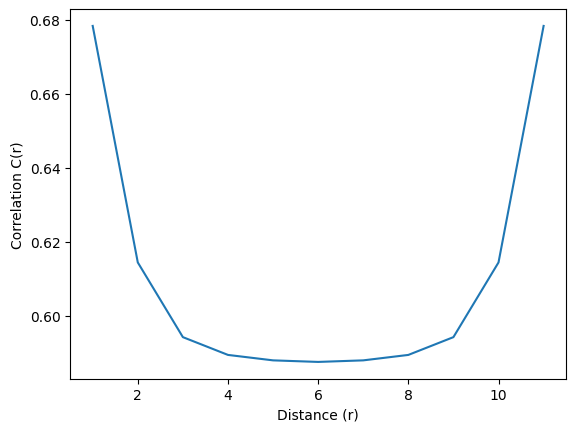

In [90]:
r = np.arange(1, n_qubits)
correlation = []

for i in r:
    correlation.append(C_r(Z2_bound_state, i))

plt.xlabel('Distance (r)')
plt.ylabel('Correlation C(r)')
plt.plot(r, np.real(correlation))

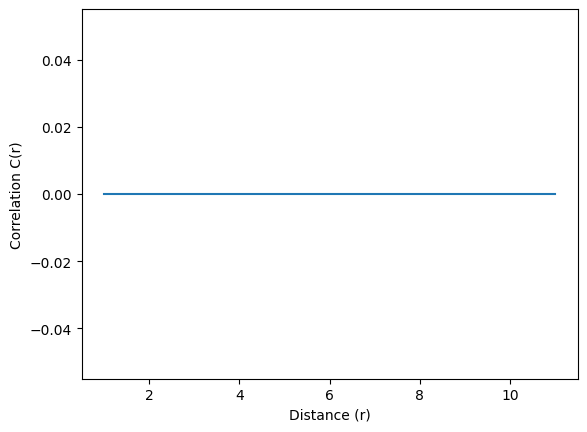

In [ ]:
r = np.arange(1, n_qubits)
correlation = []

for i in r:
    correlation.append(C_r_QSCI(ground_state, i))

plt.xlabel('Distance (r)')
plt.ylabel('Correlation C(r)')
plt.plot(r, correlation)

Fitting the correlation function to an exponential decay form:
$$
C(r) \sim e^{-r/\xi},
$$
the correlation length $\xi$ can be extracted from the decay rate. Near the critical point, the correlation length diverges, indicating long-range correlations in the system.

In [62]:
from scipy.optimize import curve_fit

def exp_decay(r, xi): 
    return np.exp(-r/xi)

popt, _ = curve_fit(exp_decay, r, np.real(correlation))
print("The correlation length ξ is:", popt[0])


The correlation length ξ is: 4.181333706684986


Now we will be calculating the correlation length for the Transverse Field Ising Model using the VQE optimized ground state wavefunction further improved using QSCI for different values of h i.e. different J/h ratios. The correlation length should diverge at the critical point, which is a characteristic feature of quantum phase transitions.

In [64]:
h = np.linspace(0.95, 1.05, 25)
correlation_len = []

for i in h:
    # Initializing the Hamiltonian Operator
    hamiltonian = construct_TFIM_hamiltonian(J, i, n_qubits)
    
    # VQE Optimization
    vqe_state = vqe(Z2_params, z2_parametric_circuit)
    state = z2_parametric_circuit.bind_parameters(vqe_state.params)
    eigs, ground_state = qsci(
        hamiltonian, [state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
    )

    coeff, cb_states = ground_state[0]

    # Computing the C(r) curve
    correlation = []
    for i in range(1, n_qubits):
        corr = 0
        for j in range(len(coeff)):
            corr += coeff[i]**2 * C_r(cb_states[i], i)
            
        correlation.append(corr)

    #Fitting to exponential decay curve
    popt, _ = curve_fit(exp_decay, r, np.real(correlation))
    correlation_len.append(popt[0])

TypeError: unsupported operand type(s) for +: 'quri_parts.rust.circuit.circuit.ImmutableQuantumCircuit' and 'float'

In [ ]:
plt.title('Correlation length (ξ) vs h/J')
plt.xlabel('h/J')
plt.ylabel('Correlation length ξ')
plt.plot(h, correlation_len)

#### **Magnetic Susceptibility**

The *magnetic susceptibility* $\chi$ is a measure of how the magnetization of a system responds to an external magnetic field. It is defined as:
$$
\chi = \frac{\partial M}{\partial h}
$$
where $M$ is the magnetization and $h$ is the transverse field. The magnetic susceptibility diverges at the critical point, indicating a phase transition.

In [ ]:
magnetization = []
h = np.linspace(0.95, 1.05, 10)

for i in h:
    hamiltonian = construct_TFIM_hamiltonian(J, i, n_qubits)
    vqe_state = vqe(vqe_state.params, H_cost_fn, H_grad_fn, adam_optimizer, hamiltonian)
    state = parametric_state.bind_parameters(vqe_state.params)

    magnetization.append(calculate_magnetization(state).value)

In [ ]:
plt.xlabel('h')
plt.ylabel('M')
plt.plot(h, np.abs(magnetization))

In [ ]:

plt.plot(h, np.gradient(np.abs(magnetization), h[1] - h[0]))

## **Reference*:*

[Transverse Field Ising Model Tutorial](https://phas.ubc.ca/~seme/516/smtutorial2.pdf)